# New bussines location indicator

### Coursera project capstone

This is the course captstone project for the coursera IBM machine learning specialization

### About the project

Having a good location for your business is an important factor for it's prosperity. although the hot spots in a city for a new venue are common knowledge, usually this places have a very high price given that this knowledge is correlated with higher demand. With some datamining and machine learning, some places cam be discovered as good opportunity’s that does not yet received peoples attention.

This project uses python, foursquare api, machine learning and visualization tools to give some insight on where you should open your business in a city.
It works by ranking the places in city by how hot they are for business and them finding what is the optimal place for a new business that does not collide with other similar business by location but also is on a "hot spot" in the city.

The data will on the amount of venues by location will be collected using the foursquare api for a given city. The app/notebook will be created in a generic way so that people using it can change the city name. 
A map of the city based on the amount of venues will be created and also another one for the similar venues as the person is looking to create.

A score for a given location that will be created by adding value for number of venues using mahalanobis distance as a weight and the using the opposite (decreasing score) by having similar venues.
In the and, points will be clustered together to have useful locations as a suggestion for the new business to open.

### Let's start by importing the libraries we will need

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium, requests, os, time, itertools, pickle
import folium.plugins as plugins
from bs4 import BeautifulSoup
from urllib.request import urlopen
from geopy.geocoders import Nominatim
from IPython.display import Image

## Defining the place of interest and search area

In [2]:
# this will be our center point in the city
lat_city_center, lng_city_center = -22.727482, -47.648811

# now, create a map with this lat and lng info
map_city = folium.Map(location=[lat_city_center, lng_city_center], zoom_start=14)
folium.CircleMarker(
        [lat_city_center, lng_city_center],
        radius=10,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(map_city)  

In [3]:
# check if it is correct
map_city

In [141]:
# Defining the search grid size and location

In [4]:
number_x_points = 10
number_y_points = 10

lat_city_center, lng_city_center = -22.727482, -47.648811
# the farthest point of interest in the map
x_max, y_max =  -22.713566, -47.659758

# now we create a distance range in lat and lng distance measure
lat_delta = 2*np.abs(x_max - lat_city_center)
lng_delta = 2*np.abs(y_max - lng_city_center)

In [5]:
# create the matrix of points for use in the map and foursquare
lat_range = np.linspace(lat_city_center - lat_delta, lat_city_center + lat_delta, number_x_points)
lng_range = np.linspace(lng_city_center - lng_delta, lng_city_center + lng_delta, number_y_points)

In [6]:
lat_range

array([-22.755314  , -22.74912911, -22.74294422, -22.73675933,
       -22.73057444, -22.72438956, -22.71820467, -22.71201978,
       -22.70583489, -22.69965   ])

In [7]:
for lat in lat_range:
    for lng in lng_range:
        folium.CircleMarker(
            [lat, lng],
            radius=10,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7,
            parse_html=False).add_to(map_city)
map_city

whe can see that we have covered most of the city with every point at around 200m from each other

## Requesting the data from the location with foursquare api

In [14]:
# Client ID and cliet secret key shoud never be stored in the notebook or other script,
# so we read it from os enviroment variable. 

VERSION = '20180605' # Foursquare API version

#CLIENT_ID = os.getenv('CLIENT_ID')          # your Foursquare ID
#CLIENT_SECRET = os.getenv('CLIENT_SECRET')  # your Foursquare Secret

In [5]:
a = os.environ.get('SENHA')
b = os.environ.get('senha')
print(a, b)

None None


Creating some help functions to get and treat the data received

In [10]:
def get_info(lat, lng):
    '''
    This function call foursquare api with given lattitude and longtude and
    returns the api response as 
    '''
    url = f'https://api.foursquare.com/v2/venues/search?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={lat},{lng}&radius={250}&limit={500}'
    results = requests.get(url).json()
    if results['meta']['code'] == 200:
        return results['response']
    return False

In [11]:
def count_venues(response):
    '''
    This function parse the response received from the get_info() function
    and treat it to filter only the number of venues in the area and retur it's number
    and a list of lat and lng data in a list o lists format
    '''
    try:
        points = []
        if response['venues']:    
            for i in range(len(response['venues'])):
                try:
                    lat = r['venues'][i]['location']['lat']
                    lng = r['venues'][i]['location']['lng']
                    points.append([lat, lng])
                except:
                    pass
            return len(response['venues']), points
    except:
        pass
    return 0, None

In [12]:
def count_similar(response, similar=['Café', 'Cafe', 'Coffe', 'Coffee Shops']):
    '''
    This function parse the response received from the get_info() function
    and count how many of then has similar text (eg: has the type we are looking for)
    and retur it's number
    '''
    total = 0 # we start with 0 matchs  
    try:
        points = []
        for venue in response['venues']:
            for item in venue['categories']:
                if  item['pluralName'] in similar or item['shortName'] in similar or item['name'] in similar:
                    total += 1
                    try:
                        lat = venue['location']['lat']
                        lng = venue['location']['lng']
                        points.append([lat, lng])
                    except:
                        pass
        return total, points
    except:
        return 0, None

In [28]:
# Let's just check the functions created
r = get_info(lat_city_center, lng_city_center)
print(f'number of coffe shops: {count_similar(r)[0]}')
print(f'number of venues in the center of the city: {count_venues(r)[0]}')
print(r['venues'][0]['location']['lat'])

number of coffe shops: 4
number of venues in the center of the city: 109
-22.727424355059128


In [29]:
print(r['venues'][0])

{'id': '4d53db6af5daa093551c6b74', 'name': 'Pernambucanas', 'location': {'address': 'R. Gov. Pedro de Toledo, 1162', 'lat': -22.727424355059128, 'lng': -47.648921896561056, 'labeledLatLngs': [{'label': 'display', 'lat': -22.727424355059128, 'lng': -47.648921896561056}], 'distance': 13, 'postalCode': '13400-063', 'cc': 'BR', 'city': 'Piracicaba', 'state': 'SP', 'country': 'Brasil', 'formattedAddress': ['R. Gov. Pedro de Toledo, 1162', 'Piracicaba, SP', '13400-063', 'Brasil']}, 'categories': [{'id': '4bf58dd8d48988d1f6941735', 'name': 'Department Store', 'pluralName': 'Department Stores', 'shortName': 'Department Store', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/departmentstore_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1580612966', 'hasPerk': False}


Now, we will search in all the opoints in the map

In [30]:
# the flag bellow is to avoid excess use of the api, loading the data if it already exists
new_scrap = False

filename = 'foursquare_data.pk'
if new_scrap:
    full_response, points_coffe, points_venue = [], [], []
    for lat in lat_range:
        line = []
        for lng in lng_range:
            r = get_info(lat, lng)
            similar, pt_temp_cofee = count_similar(r)
            venues, pt_temp_venue = count_venues(r)
            if pt_temp_venue:
                points_venue.extend(pt_temp_venue)
            if pt_temp_cofee:
                points_coffe.extend(pt_temp_cofee)
            line.append((similar, venues))
            time.sleep(1)
        full_response.append(line) 
    outfile = open(filename, 'wb')
    pickle.dump([full_response, points_coffe, points_venue], outfile)
    outfile.close()
else:
    infile = open(filename,'rb')
    full_response, points_coffe, points_venue = pickle.load(infile)
    infile.close()

In [36]:
# let's check what we got:

print(type(full_response),len(full_response), full_response[0])

<class 'list'> 10 [(0, 190), (0, 177), (0, 186), (0, 191), (0, 178), (0, 131), (0, 155), (0, 161), (0, 113), (0, 104)]


Let's just see the data format and visualize the results

In [39]:
# to plot a heatmap using folium.plugins.HeatMap, we will generate a data in the expected format
venue_matrix = np.zeros([number_x_points*number_y_points, 3])
coffe_matrix = np.zeros([number_x_points*number_y_points, 3])

# flatten the full response for easy of use
full_response_flat = list(itertools.chain(*full_response))

# now, populate the matrix with the info from "full_response" list from foursquare
i = 0
for lat in lat_range:
    for lng in lng_range:
        coffe_matrix[i] = (lat, lng, full_response_flat[i][0])
        venue_matrix[i] = (lat, lng, full_response_flat[i][1])
        i += 1

In [40]:
# and do some data threatment and formating

max_venue = venue_matrix[:,2].max()
min_venue = venue_matrix[:,2].min()
venue_matrix_normalized = (venue_matrix[:,2] - min_venue)/(max_venue - min_venue)

To plot using folium heatmap, we will create a list of points in the expected format:

In [41]:
points_venue = []
for venue in venue_matrix:
    for i in range(int((venue[2]/10))):
        points_venue.append([venue[0], venue[1]])

In [42]:
points_coffe = []
for venue in coffe_matrix:
    for i in range(int((venue[2]))):
        points_coffe.append([venue[0], venue[1]])

In [52]:
m_venues = folium.Map(location=[lat_city_center, lng_city_center], zoom_start=14)
m_venues.add_child(folium.plugins.HeatMap(points_venue, radius=10, min_opacity=0.2, blur=8, control_scale=False))
m_venues

In [44]:
m_cofee = folium.Map(location=[lat_city_center, lng_city_center], zoom_start=14)
m_cofee.add_child(folium.plugins.HeatMap(points_coffe, radius=70, min_opacity=0.2, blur=35, control_scale=False))
m_cofee

if both graphs where not able to render properly (the are some known bugs no mozilla for the heamap generation *), here are the plots as jped images

* https://github.com/python-visualization/folium/issues/812

We will use k-means and the Elbow Method to see the ammount of clusters for existing coffe shops and general venues

In [53]:
from sklearn.cluster import KMeans

In [131]:
def find_elbow_k(point):
    sse = []
    for k in range(1,10):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(points_coffe)
        pred_clusters = kmeans.predict(point)
        centroids = kmeans.cluster_centers_
        curr_sse = 0
        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points_coffe)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += (point[i][0] - curr_center[0]) ** 2 + (point[i][1] - curr_center[1]) ** 2     
        sse.append(curr_sse)
    return sse

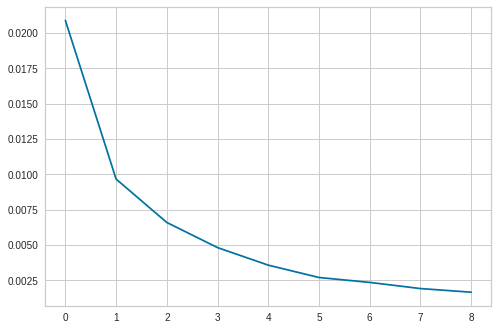

In [138]:
point = points_coffe
sse = find_elbow_k(point)
plt.plot(sse)

We can see that 4 or 5 blobs are a good start for places with coffe shops

In [141]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(points_coffe)
pred_clusters = kmeans.predict(point)
centroids = kmeans.cluster_centers_

In [142]:
m_cofee2 = folium.Map(location=[lat_city_center, lng_city_center], zoom_start=14)
m_cofee2.add_child(folium.plugins.HeatMap(points_coffe, radius=70, min_opacity=0.2, blur=35, control_scale=False))
for centroid in centroids:
    folium.CircleMarker(
        centroid,
        radius=10,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(m_cofee2)
m_cofee2

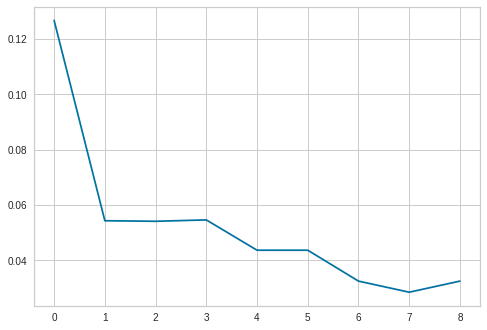

In [143]:
point = points_venue
sse = find_elbow_k(point)
plt.plot(sse)

for the general vennues, there is no direct group separations

## 